Procedure for smearing
---------------------------------
There are two things you have to account for : muon-> neutrino scattering angle and error in reconstruction of muon direction.

The first  quantity is given in the variables PSF_min[deg]  PSF_max[deg] and the second in AngErr_min[deg]  AngErr_max[deg] in the files

1. For each neutrino energy and declination choose the average of PSF_min and PSF_max as well as average of AngErr_min[deg]  AngErr_max[deg]  and add them in quadrature. 
        This will give you the total angular uncertainty. ($\theta_{tot}$)

- For each simulated neutrino, take average of PSF_min and PSF_max as well as average of AngErr_min[deg]  AngErr_max[deg] and calculate $\sqrt{PSF_{avg}^2 + AngErr_{avg}^2}$

2. convert the simulated RA and DEC to theta  ($\theta_{mock}$) and phi  ($\phi_{mock}$) for the simulated MJD 

- Choose simulated MJD  to be uniformly distributed for each phase

3. assume error in theta=error in phi =($\theta_{tot}$)/$\sqrt(2)$

then choose Gausian distributed random numbers with **mean=0** and standard deviation = error in theta as well as error in phi.

This will give you the error in theta  ($\Delta \theta_{mock}$) and error in phi  ($\Delta \phi_{mock}$) for the simulated neutrino event

New theta=$\theta_{mock}$+$\Delta \theta_{mock}$

and New phi=$\phi_{mock}$+$\Delta \phi_{mock}$

4. Calculate new RA and DEC from new theta and new phi . This will be the smeared RA and DEC of the muon

5. as a sanity check calculate the angle between the smeared muon and the original pulsar direction. It should be close to $\theta_{tot}$.

Again all this should be in a separate code and decoupled from the routine to 
do the search.





 





In [1]:
from astropy.units import deg, meter
from astropy.coordinates import ICRS, get_sun, SkyCoord, AltAz, EarthLocation
from astropy.time import Time
####syn_nu_ze
import numpy as np
import os
import multiprocessing as mul
import matplotlib.pyplot as plt
from numba import jit, njit, prange, set_num_threads, vectorize, guvectorize, cuda
from tqdm import tqdm
import pandas as pd

os.system("cp -r ./o_data/icecube_10year_ps/events/ ./data/icecube_10year_ps/")

In [53]:


from core.signal_bag import *
from core.stacking_analysis import *
from core.req_arrays import *
print(icwidths)


[70926, 107011, 93133, 136244, 112855, 122539, 127040, 129307, 123654, 145748]


In [3]:
latitude = -89.99
longitude = 13.2536#-63.453056
location = EarthLocation(lat=latitude * deg, lon=longitude * deg, height = 2835*meter)

def ra_dec_to_azimuth_zenith(ra_deg, dec_deg, obs_mjd):
    
    # Convert MJD to Time object
    obs_time = Time(obs_mjd, format='mjd')

    # Create a SkyCoord object with the given RA and Dec
    coord = SkyCoord(ra=ra_deg * deg, dec=dec_deg* deg, frame='icrs')

    # Convert to Altitude and Azimuth coordinates
    altaz = coord.transform_to(AltAz(location=location ,obstime=obs_time))

    # Calculate zenith angle (90° - altitude)
    # zenith_angle_deg = 90.0 - altaz.alt.deg
    alt_angle_deg = altaz.alt.deg

    # Extract Azimuth and Zenith Angle values (in degrees)
    azimuth_deg = altaz.az.deg
    
    return (azimuth_deg, alt_angle_deg)


def altaz_to_radec(azimuth, alt, mjd):
    
    # Convert zenith angle to altitude
    # altitude = (90 - zenith) * deg
    altitude = alt * deg
    
    # Convert MJD to Time object
    observing_time = Time(mjd, format='mjd', scale='utc')
    
    # Create EarthLocation
    
    # Create AltAz coordinate
    altaz = AltAz(location=location, obstime=observing_time)
    
    # Create SkyCoord from AltAz
    altaz_coord = SkyCoord(alt=altitude, az=azimuth, frame=altaz, unit=(deg, deg))
    
    # Convert AltAz coordinates to RA and Dec
    equatorial_coord = altaz_coord.transform_to('icrs')
    
    
    ra_deg = equatorial_coord.ra.deg
    dec_deg = equatorial_coord.dec.deg
    
    return (ra_deg, dec_deg)





In [54]:
icsmear_k = pd.read_csv('./data/icecube_10year_ps/irfs/IC40_smearing.csv', sep='\s+', comment='#', names='log10(E_nu/GeV)_min	log10(E_nu/GeV)_max	Dec_nu_min[deg]	Dec_nu_max[deg]	log10(E/GeV)_min	log10(E/GeV)_max	PSF_min[deg]	PSF_max[deg]	AngErr_min[deg]	AngErr_max[deg]	Fractional_Counts'.split('\t'), dtype=float)

In [59]:
icsmear_k_log_E = np.array(list(set(icsmear_k['log10(E_nu/GeV)_min'])))#.union(set(icsmear_k['log10(E_nu/GeV)_max']))))
log_E_width = 26400
icsmear_k_log_E.sort()

# icsmear_k_log_E = 10**(icsmear_k_log_E+9)

# icsmear_k_dec = np.array(list(set(icsmear_k['Dec_nu_min[deg]']).union(set(icsmear_k['Dec_nu_max[deg]']))))
icsmear_k_dec = np.ravel(list(set(icsmear_k['Dec_nu_min[deg]'])))
icsmear_k_psf = np.array(list(set(icsmear_k['PSF_min[deg]']).union(set(icsmear_k['PSF_max[deg]']))))

icsmear_k_dec.sort()
dec_width = 123200

In [68]:
nbins = 500
n_psrs = 30
season = 0
icsmear_k = pd.read_csv('./data/icecube_10year_ps/irfs/IC40_smearing.csv', sep='\s+', comment='#', names='log10(E_nu/GeV)_min	log10(E_nu/GeV)_max	Dec_nu_min[deg]	Dec_nu_max[deg]	log10(E/GeV)_min	log10(E/GeV)_max	PSF_min[deg]	PSF_max[deg]	AngErr_min[deg]	AngErr_max[deg]	Fractional_Counts'.split('\t'), dtype=float)
icsmear_k_log_E = np.array(list(set(icsmear_k['log10(E_nu/GeV)_min'])))#.union(set(icsmear_k['log10(E_nu/GeV)_max']))))
log_E_width = 26400
icsmear_k_log_E.sort()

icsmear_k_dec = np.ravel(list(set(icsmear_k['Dec_nu_min[deg]'])))
icsmear_k_dec.sort()




enus = np.logspace(11.001, 18.999, int(nbins))
enus_bin_indices = np.digitize(enus, e_nu_wall) - 1
msdec_bin_indices = np.digitize(msdec, dec_nu) - 1


gamma_arr = [-2, -2.2, -2.53, -3]


syn_nu_choice = np.random.randint(0, p, n_psrs) #Choose 50 random pulsars from the 3389 pulsars
syn_nudec_bin = msdec_bin_indices[syn_nu_choice] #Find the declination bin of the chosen pulsars to be allocated for the synthetic neutrinos
syn_nu_ra = msra[syn_nu_choice] #Find the right ascension of the chosen pulsars to be allocated for the synthetic neutrinos
syn_nu_dec = msdec[syn_nu_choice] #Find the declination of the chosen pulsars to be allocated for the synthetic neutrinos


phio_const = 4.98 * (10**(-28)) #GeV-1 to ev-1 conversion factor

# phio_const *= 1e-5
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
        "IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]





def get_syn_nu_dec(season_i):
    

    icdata_k = pd.read_csv("./o_data/icecube_10year_ps/events/" + filenames[season_i], sep="\s+", comment="#", names="MJD[days]	log10(E/GeV)	AngErr[deg]	RA[deg]	Dec[deg]	Azimuth[deg]	Zenith[deg]".split("\t"), dtype=float)


    uptdata_k = pd.read_csv("./o_data/icecube_10year_ps/uptime/" + filenames[season_i], sep="\s+", comment="#", names=["MJD_start[days]","MJD_stop[days]"], dtype=float, index_col=False)
    
    max_stop = max(uptdata_k["MJD_stop[days]"].values)
    min_start = min(uptdata_k["MJD_start[days]"].values)
    # uptdata_k = []
    icsmear_k = []
    try:
        icsmear_k = pd.read_csv("./o_data/icecube_10year_ps/irfs/" + filenames[season_i].replace('exp', 'smearing'), sep="\s+", comment="#", names='log10(E_nu/GeV)_min	log10(E_nu/GeV)_max	Dec_nu_min[deg]	Dec_nu_max[deg]	log10(E/GeV)_min	log10(E/GeV)_max	PSF_min[deg]	PSF_max[deg]	AngErr_min[deg]	AngErr_max[deg]	Fractional_Counts'.split('\t'), dtype=float)
    except:
        icsmear_k = pd.read_csv("./o_data/icecube_10year_ps/irfs/" + filenames[4].replace('exp', 'smearing'), sep="\s+", comment="#", names='log10(E_nu/GeV)_min	log10(E_nu/GeV)_max	Dec_nu_min[deg]	Dec_nu_max[deg]	log10(E/GeV)_min	log10(E/GeV)_max	PSF_min[deg]	PSF_max[deg]	AngErr_min[deg]	AngErr_max[deg]	Fractional_Counts'.split('\t'), dtype=float)
        # print(temp1)
    enus_smear_bin_min = icsmear_k_log_E[ np.digitize(np.log10(enus/1e9), icsmear_k_log_E) - 1]
    nu_smear_dec_bin_min = icsmear_k_dec[ np.digitize(syn_nu_dec, icsmear_k_dec) - 1]
    n_nu = 0
    dada = []
    adad = []
    for i in tqdm(range(len(enus))):    
        
        temp1 = icsmear_k[icsmear_k["log10(E_nu/GeV)_min"] == enus_smear_bin_min[i]]
        
        for j in range(len(syn_nu_dec)):
        
            temp2 = temp1[temp1["Dec_nu_min[deg]"] == nu_smear_dec_bin_min[j]]        
            psf_avg = (min(temp2["PSF_min[deg]"]) + max(temp2["PSF_max[deg]"])) / 2
            
       
            angerr_avg = (min(temp2["AngErr_min[deg]"]) + max(temp2["AngErr_max[deg]"])) / 2
            theta_tot = np.sqrt(psf_avg**2 + angerr_avg**2)
            adad.append(theta_tot)
            # No.of neutrinos to be generated in this season, in this energy bin, in this declination bin
            n_nu_temp = t_upt[season_i] * earea[ea_season(season_i)][syn_nudec_bin[j] * 40 + enus_bin_indices[i]] * enus[i] * phio_const * ((enus[i] / 10**14) ** gamma_arr[2])
            
            
            n_nu_temp = int(n_nu_temp)
            # print(n_nu_temp)
            n_nu += n_nu_temp
            if n_nu_temp > 0:
                mjd = np.random.uniform(min_start, max_stop, n_nu_temp)
                temp_ra = np.ones(n_nu_temp, dtype=np.float64) * syn_nu_ra[j]
                temp_dec = np.ones(n_nu_temp, dtype=np.float64) * syn_nu_dec[j]
                
                
                
                syn_nu_az, syn_nu_alt = ra_dec_to_azimuth_zenith(temp_ra, temp_dec, mjd)
                
                errs = np.random.normal(0, theta_tot/(2**0.5), n_nu_temp)
                
                syn_nu_az += errs
                syn_nu_alt += errs
                
                for xx in prange(len(syn_nu_alt)):
                    if syn_nu_alt[xx] > 90:
                        # 91 degrees altitude should correspond to 89 degrees altitude
                        # so we take the negative of the angle and add 180 degrees
                        syn_nu_alt[xx] = 180 - syn_nu_alt[xx]
                    
                    elif syn_nu_alt[xx] < -90:
                        # -91 degrees altitude should correspond to -89 degrees altitude
                        # so we take the negative of the angle and add -180 degrees
                        syn_nu_alt[xx] = -180 - syn_nu_alt[xx]
                    else:
                        pass
                    
                
                
                syn_ra, syn_dec = [], []
                
                
                for temp_i in range(len(syn_nu_az)):
                    tra, tdec = altaz_to_radec(syn_nu_az[temp_i], syn_nu_alt[temp_i], mjd[temp_i])
                    syn_ra.append(tra)
                    syn_dec.append(tdec)
                    
                syn_ra = np.array(syn_ra)
                syn_dec = np.array(syn_dec)
                
                dada.append(max(hvovec(syn_ra, syn_dec, syn_nu_ra[j], syn_nu_dec[j])))
                temp3 = pd.DataFrame(np.vstack([mjd, -1 * np.ones(len(mjd)), errs, syn_ra, syn_dec, syn_nu_az, syn_nu_alt]).T)
                temp3.columns = "MJD[days]	log10(E/GeV)	AngErr[deg]	RA[deg]	Dec[deg]	Azimuth[deg]	Zenith[deg]".split('\t')
                icdata_k = pd.concat([icdata_k, temp3], ignore_index=True, axis=0)
                
                
            else:
                continue
            
    icdata_k.to_csv("./data/icecube_10year_ps/events/" + filenames[season_i], sep="\t", index=False)
    print("Done with season", season_i)
    
    print(season_i, len(icdata_k.index))
    print("No.of neutrinos generated:")
    print(n_nu)
    return (dada, adad)

In [69]:
pool = mul.Pool(12)
op_async = pool.map_async(get_syn_nu_dec, tqdm(range(1, 3)))
drive = op_async.get()
pool.close()
pool.join()
op_async = []
print("Generated Synthetic neutrinos and added to original IceCube Data")

 73%|███████▎  | 367/500 [00:59<00:07, 18.77it/s]

Done with season 1
1 112695
No.of neutrinos generated:
5684


100%|██████████| 500/500 [01:05<00:00,  7.60it/s]


Done with season 2
2 100559
No.of neutrinos generated:
7426
Generated Synthetic neutrinos and added to original IceCube Data


In [70]:
dada = []
adad = []
for i in drive:
    dada.extend(i[0])
    adad.extend(i[1])

(array([0.00662889, 0.0014637 , 0.00617148, 0.0025087 , 0.00130889,
        0.00141796, 0.        , 0.00056296, 0.00141796, 0.        ,
        0.00307167, 0.00307167, 0.00054537, 0.00109074, 0.00436296,
        0.00453537, 0.00908833, 0.0169487 , 0.04136019]),
 array([  0.        ,   9.47368421,  18.94736842,  28.42105263,
         37.89473684,  47.36842105,  56.84210526,  66.31578947,
         75.78947368,  85.26315789,  94.73684211, 104.21052632,
        113.68421053, 123.15789474, 132.63157895, 142.10526316,
        151.57894737, 161.05263158, 170.52631579, 180.        ]),
 <BarContainer object of 19 artists>)

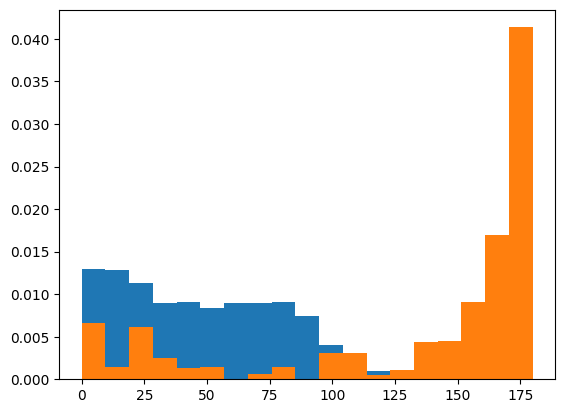

In [89]:
plt.hist(dada, density=True, bins=np.linspace(0, 180, 20))
plt.hist(np.multiply(2, adad), density=True, bins=np.linspace(0, 180, 20))

(array([0.00986848, 0.00217903, 0.00834945, 0.00457282, 0.00194855,
        0.00211093, 0.        , 0.00083809, 0.        , 0.00211093,
        0.00457282, 0.00211093, 0.00246188, 0.0008119 , 0.00162379,
        0.00730708, 0.00953849, 0.01074324, 0.02441978, 0.06157325]),
 array([  0.        ,   6.36369396,  12.72738791,  19.09108187,
         25.45477583,  31.81846978,  38.18216374,  44.5458577 ,
         50.90955165,  57.27324561,  63.63693957,  70.00063352,
         76.36432748,  82.72802144,  89.09171539,  95.45540935,
        101.81910331, 108.18279727, 114.54649122, 120.91018518,
        127.27387914]),
 <BarContainer object of 20 artists>)

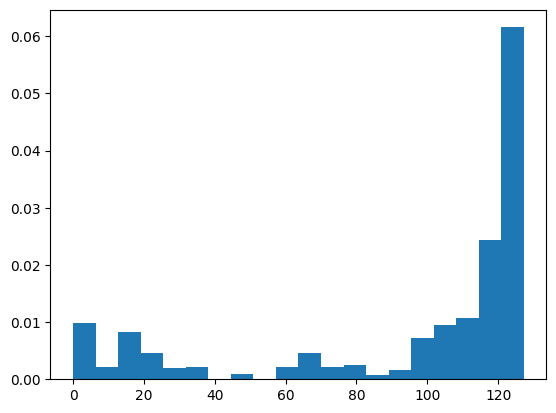

In [72]:
plt.hist(np.multiply(2**0.5, adad), density=True, bins=20)

(array([1.26735913e-02, 1.30817585e-02, 1.16735817e-02, 8.89804479e-03,
        9.71437917e-03, 8.08171040e-03, 9.06131166e-03, 8.32661072e-03,
        9.67356245e-03, 8.22456892e-03, 5.79597413e-03, 3.08166230e-03,
        1.18368486e-03, 8.77559463e-04, 2.65308675e-04, 2.04083596e-04,
        2.24491956e-04, 1.42858517e-04, 8.16334384e-05, 4.08167192e-05]),
 array([1.02472617e-02, 8.99439259e+00, 1.79785379e+01, 2.69626832e+01,
        3.59468286e+01, 4.49309739e+01, 5.39151192e+01, 6.28992645e+01,
        7.18834099e+01, 8.08675552e+01, 8.98517005e+01, 9.88358458e+01,
        1.07819991e+02, 1.16804136e+02, 1.25788282e+02, 1.34772427e+02,
        1.43756572e+02, 1.52740718e+02, 1.61724863e+02, 1.70709008e+02,
        1.79693154e+02]),
 <BarContainer object of 20 artists>)

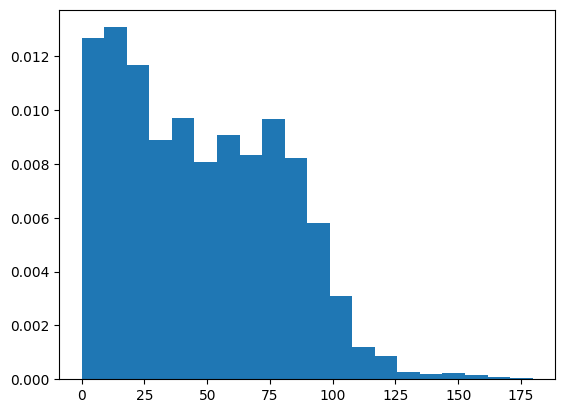

In [73]:
plt.hist(dada, density=True, bins=20)

In [74]:
print(icwidths)

[70926, 107011, 93133, 136244, 112855, 122539, 127040, 129307, 123654, 145748]


In [81]:
icdata_k = pd.read_csv("./data/icecube_10year_ps/events/" + filenames[1], sep="\s+", comment="#", names="MJD[days]	log10(E/GeV)	AngErr[deg]	RA[deg]	Dec[deg]	Azimuth[deg]	Zenith[deg]".split("\t"), dtype=float, skiprows=1)

In [82]:
pd.read_csv("./data/icecube_10year_ps/events/" + filenames[1], sep="\s+")

,MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
0,54971.158700,3.43,1.070000,128.331000,53.070000,256.558000,143.042000
1,54971.159571,3.37,1.190000,223.406000,1.740000,161.854000,91.693000
2,54971.161645,5.37,0.530000,332.873000,-24.509000,53.126000,65.540000
3,54971.164300,5.43,0.330000,243.988000,-74.954000,142.781000,15.016000
4,54971.166343,5.33,0.550000,36.228000,-22.282000,351.498000,67.767000
...,...,...,...,...,...,...,...
112690,55346.436661,-1.00,71.458780,353.649968,-69.660092,295.493418,69.600427
112691,55208.185640,-1.00,15.944505,300.127571,-15.778549,108.619810,15.748043
112692,54977.888846,-1.00,19.429800,305.185869,-15.995869,87.514523,15.965744
112693,54994.677650,-1.00,29.727599,311.881936,-27.918024,153.703363,27.872011


In [83]:
icdata_k

,MJD[days],log10(E/GeV),AngErr[deg],RA[deg],Dec[deg],Azimuth[deg],Zenith[deg]
0,54971.158700,3.43,1.070000,128.331000,53.070000,256.558000,143.042000
1,54971.159571,3.37,1.190000,223.406000,1.740000,161.854000,91.693000
2,54971.161645,5.37,0.530000,332.873000,-24.509000,53.126000,65.540000
3,54971.164300,5.43,0.330000,243.988000,-74.954000,142.781000,15.016000
4,54971.166343,5.33,0.550000,36.228000,-22.282000,351.498000,67.767000
...,...,...,...,...,...,...,...
112690,55346.436661,-1.00,71.458780,353.649968,-69.660092,295.493418,69.600427
112691,55208.185640,-1.00,15.944505,300.127571,-15.778549,108.619810,15.748043
112692,54977.888846,-1.00,19.429800,305.185869,-15.995869,87.514523,15.965744
112693,54994.677650,-1.00,29.727599,311.881936,-27.918024,153.703363,27.872011
